In [1]:
#with recurrent dropout but without sliding==>not learning or it's overfitting at start
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def rnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))    
    model.add(Dense(32,activation='elu'))
    model.add(Dropout(0.5))    
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    return model

In [6]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=100,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for i in range(y_pred.shape[0]):
        label_true = np.argmax(y_test[i])
        label_pred = np.argmax(y_pred[i])
        confusion_matrix[label_true, label_pred] += 1
        if label_true == label_pred:
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy,confusion_matrix

In [8]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')
y_train = y_train_valid
y_test = y_test

Train on 1692 samples, validate on 423 samples
Epoch 1/100
1692/1692 [==============================] - 4s 3ms/step - loss: 19.1985 - acc: 0.2677 - val_loss: 17.2029 - val_acc: 0.2695
Epoch 2/100
1692/1692 [==============================] - 2s 1ms/step - loss: 17.7033 - acc: 0.3097 - val_loss: 16.2186 - val_acc: 0.3073
Epoch 3/100
1692/1692 [==============================] - 2s 1ms/step - loss: 16.3717 - acc: 0.3658 - val_loss: 15.3989 - val_acc: 0.2742
Epoch 4/100
1692/1692 [==============================] - 2s 1ms/step - loss: 15.0855 - acc: 0.4557 - val_loss: 14.6357 - val_acc: 0.3097
Epoch 5/100
1692/1692 [==============================] - 2s 1ms/step - loss: 14.1500 - acc: 0.5219 - val_loss: 14.0382 - val_acc: 0.2908
Epoch 6/100
1692/1692 [==============================] - 2s 1ms/step - loss: 13.1219 - acc: 0.5934 - val_loss: 13.4071 - val_acc: 0.3026
Epoch 7/100
1692/1692 [==============================] - 2s 1ms/step - loss: 12.2017 - acc: 0.6743 - val_loss: 12.9836 - val_acc: 0

Epoch 61/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.7465 - acc: 0.9403 - val_loss: 5.5219 - val_acc: 0.3144
Epoch 62/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.7540 - acc: 0.9326 - val_loss: 5.5977 - val_acc: 0.2955
Epoch 63/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.7857 - acc: 0.9379 - val_loss: 5.5982 - val_acc: 0.2979
Epoch 64/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.8702 - acc: 0.9297 - val_loss: 5.4008 - val_acc: 0.3050
Epoch 65/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.8829 - acc: 0.9238 - val_loss: 5.2261 - val_acc: 0.2908
Epoch 66/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.8071 - acc: 0.9492 - val_loss: 5.3975 - val_acc: 0.2813
Epoch 67/100
1692/1692 [==============================] - 2s 1ms/step - loss: 1.7014 - acc: 0.9634 - val_loss: 5.3941 - val_acc: 0.2884
Epoch 68/100
1692/1692 [========================

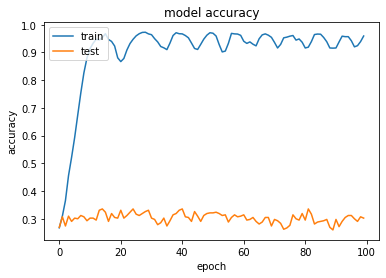

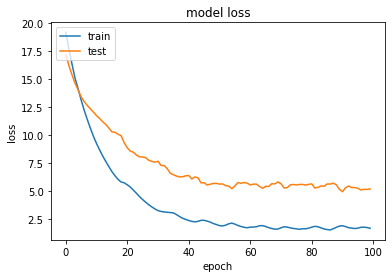

0.30248306997742663
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 22, 128)           545280    
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 22, 128)           98816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 128)           512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None

In [9]:
def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = rnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc,c_matrix = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = RNN(x_train,y_train,x_test,y_test)